In [1]:
import pandas as pd

In [2]:
df = pd.read_json('data/tweetsdata.json')

In [3]:
df1 = df.copy()

In [4]:
df1 = df1.set_index('date')

In [5]:
df1 = df1.loc[:,['tweet', 'tweetType']]

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.3)
rcParams['figure.figsize'] = 12,8

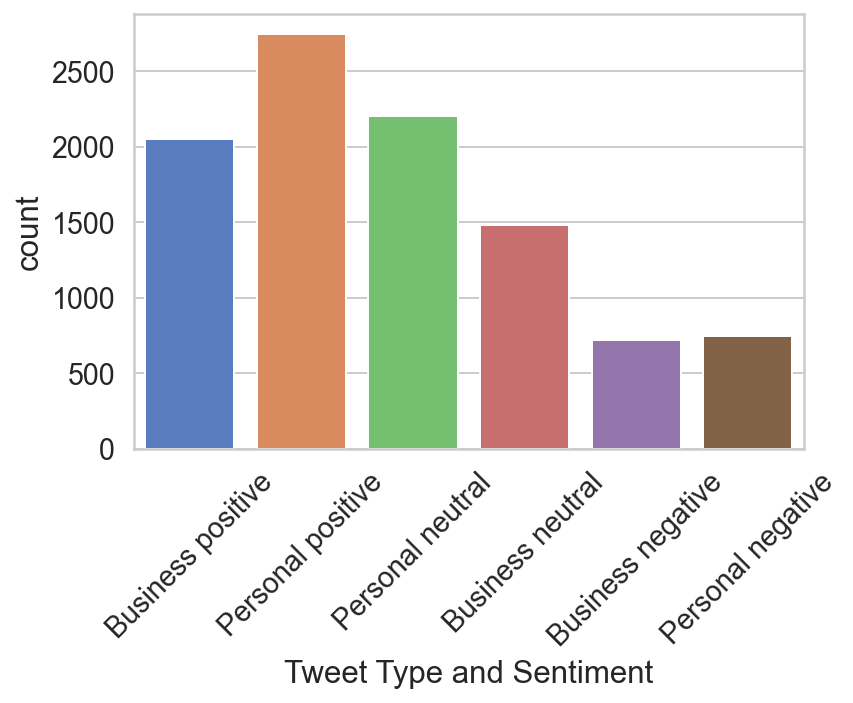

In [7]:
sns.countplot(df.tweetType);
plt.xlabel('Tweet Type and Sentiment')
plt.xticks(rotation = 45);

In [8]:
df1['tweetTypeCode'] = df1['tweetType'].astype('category').cat.codes

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
random_state = 777

In [10]:
#Business Positive is 2, Business Neutral is 1, Business Negative is 0
#Personal Positive is 5, Personal Neutral is 4, Personal Negative is 3
targetName = ['Business negative', 'Business neutral', 'Business positive',
             'Personal negative', 'Personal neutral', 'Personal positive']

In [11]:
import nltk
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings("ignore")

In [12]:
#Text Preprocessing 
#remove webpage 
#can't remove @ or # as he might be mentioning or hashtaging Tesla or a news agency 
#lowercase
#remove punctuations- create a list of common punctuations 
#need to keep numbers - since we are dealing with stocks 
#use stopwords 
#keep emojis
#tokenize
#can't remove shortwords since car model names 
#https://www.ranks.nl/stopwords
#remove English stopwords 
stopwords = ['a','about','above','after', 'again', 'against','all', 'am', 'an', 'and', 'any', 'are', 'aren\'t', 'as',
             'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'can\'t', 'cannot',
             'could', 'couln\'t', 'did', 'didn\'t', 'did', 'didn\'t', 'do', 'does', 'does\'t', 'doing', 'don\'t',
             'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn\'t', 'has', 'hasn\'t', 'have',
             'haven\'t', 'having', 'he', 'he\'d', 'he\'ll', 'he\'s', 'her', 'here', 'here\'s', 'hers', 'herself',
             'him', 'himself', 'his', 'how', 'how\'s', 'i', 'i\'d', 'i\'ll', 'i\'m', 'i\'ve', 'if', 'in', 'into',
             'is', 'isn\'t', 'it', 'it\'s', 'its', 'itself', 'let\'s', 'me', 'more' 'most', 'mustn\'t', 'my', 'myself',
             'no', 'nor', 'not', 'of', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves',
             'out', 'over', 'own', 'same', 'shan\'t', 'she', 'she\'d', 'she\'ll', 'she\'s', 'should', 'shouldn\'t',
             'so', 'some', 'such', 'than', 'that', 'that\'s', 'the', 'their', 'theirs', 'them', 'themselves', 'then',
             'there', 'there\'s', 'these', 'they', 'they\'d', 'they\'ll', 'they\'re', 'they\'ve', 'this', 'those',
             'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn\'t', 'we', 'we\'d', 'we\'ll',
             'we\'re', 'we\'ve', 'were', 'weren\'t', 'what', 'what\'s', 'when', 'when\'s', 'where', 'where\'s',
             'which', 'while', 'who', 'who\'s', 'whom', 'why', 'why\'s', ' with', 'won\'t', 'wouldn\'t', 'you',
             'you\'d', 'you\'ll', 'you\'re', 'you\'ve', 'your', 'yours', 'yourself', 'yourselves']

#remove punctuation from tweets 
punc = lambda x: re.sub("!|,|\?|\'|-|\"|&|。|\)|\(|！|，|\.*|/|\[|\]|\u2026|\d|:|~|、|？|☆|’|– |【|】|「|」|《|》|※| “|”|＊|→||[\b\.\b]{3}||@||@ |#|# |", '',x)



def clean_tweet(tweet):
    #remove stopwords
    #use beautiful soup to remove the &/amps etc in tweets as well as website links 
    soup_ = BeautifulSoup(tweet, 'lxml')
    soup_ = soup_.get_text()
    soup_ = re.sub(r'https?://[A-Za-z0-9./]+', '', soup_) 
 
    #lowercase the words and remove punctuation
    lower_ = ''.join([word.lower() for word in soup_])

    #remove puncutations using a custom list
    punc_ = ''.join([punc(word) for word in lower_])
    #tokenize
    token_ = re.split('\W+',punc_)
    #remove stopwords
    stop_ = [word for word in token_ if word not in stopwords]
    tweet = ' '.join(word for word in stop_)

    return tweet


In [13]:
df1['cleanTweet'] = df1['tweet'].apply(clean_tweet)

In [14]:
#Get rid of blank tweets removed from cleaning 
df1 = df1[df1['cleanTweet'] != '']

In [15]:
df1 = df1.reset_index(drop = True)

In [16]:
df1.head()

,tweet,tweetType,tweetTypeCode,cleanTweet
0,"Physics favors electric transport, batteries f...",Business positive,2,physics favors electric transport batteries st...
1,Major Supercharger increases are underway for ...,Business positive,2,major supercharger increases underway greater ...
2,For sure,Personal positive,5,sure
3,"Verified should be far more widespread, simply...",Personal neutral,4,verified far more widespread simply someone claim
4,It’s a tough one. That’s why we should expand ...,Personal positive,5,tough one thats expand scope scale consciousne...


In [17]:
#TFIDF vectorizer 
tfidf = TfidfVectorizer()

#Column Transformer to avoid Data Leakage 
ct = make_column_transformer(
    (tfidf, 'cleanTweet'),
    remainder='passthrough')

In [18]:
count_vect = CountVectorizer()

#CV column transformer

ct2 = make_column_transformer(
    (count_vect, 'cleanTweet'),
    remainder = 'passthrough')

In [19]:
df2 = df1.loc[:,['tweetTypeCode', 'cleanTweet']].reset_index(drop = True)

In [20]:
X = df2[['cleanTweet']]
y = df2[['tweetTypeCode']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = random_state)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7872, 1), (1968, 1), (7872, 1), (1968, 1))

In [22]:
#Different Classification algorithms to try #SVM, #Naive BAYES, #LogisticRegression, #RandomForest, #Xgboost

In [23]:
#Algos
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Metrics
from sklearn.metrics import classification_report

average=micro says the function to compute f1 by considering total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset)

average=macro says the function to compute f1 for each label, and returns the average without considering the proportion for each label in the dataset.

average=weighted says the function to compute f1 for each label, and returns the average considering the proportion for each label in the dataset.

average=samples says the function to compute f1 for each instance, and returns the average. Use it for multilabel classification.

In [24]:
#####Suppor Vector Machines#######

In [25]:
svc = SVC()
model1 = make_pipeline(ct, svc)
model1.fit(X_train,y_train);

In [26]:
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.00      0.00      0.00       149
 Business neutral       0.00      0.00      0.00       306
Business positive       0.00      0.00      0.00       415
Personal negative       0.00      0.00      0.00       155
 Personal neutral       0.00      0.00      0.00       430
Personal positive       0.26      1.00      0.41       513

         accuracy                           0.26      1968
        macro avg       0.04      0.17      0.07      1968
     weighted avg       0.07      0.26      0.11      1968



In [27]:
svc = SVC()
model1c = make_pipeline(ct2, svc)
model1c.fit(X_train,y_train);

In [28]:
y_pred1c = model1c.predict(X_test)
print(classification_report(y_test, y_pred1c, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.00      0.00      0.00       149
 Business neutral       0.00      0.00      0.00       306
Business positive       0.00      0.00      0.00       415
Personal negative       0.00      0.00      0.00       155
 Personal neutral       0.00      0.00      0.00       430
Personal positive       0.26      1.00      0.41       513

         accuracy                           0.26      1968
        macro avg       0.04      0.17      0.07      1968
     weighted avg       0.07      0.26      0.11      1968



In [29]:
##### Multinomial Naive Bayes#######

In [30]:
mb = MultinomialNB()
model2 = make_pipeline(ct, mb)
model2.fit(X_train,y_train);

In [31]:
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.00      0.00      0.00       149
 Business neutral       0.68      0.21      0.32       306
Business positive       0.40      0.78      0.52       415
Personal negative       1.00      0.01      0.03       155
 Personal neutral       0.68      0.29      0.40       430
Personal positive       0.48      0.82      0.61       513

         accuracy                           0.48      1968
        macro avg       0.54      0.35      0.31      1968
     weighted avg       0.54      0.48      0.41      1968



In [32]:
mb = MultinomialNB()
model2c = make_pipeline(ct2, mb)
model2c.fit(X_train,y_train);

In [33]:
y_pred2c = model2c.predict(X_test)
print(classification_report(y_test, y_pred2c, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.36      0.13      0.20       149
 Business neutral       0.56      0.38      0.45       306
Business positive       0.42      0.77      0.54       415
Personal negative       0.78      0.18      0.29       155
 Personal neutral       0.71      0.30      0.42       430
Personal positive       0.54      0.76      0.63       513

         accuracy                           0.51      1968
        macro avg       0.56      0.42      0.42      1968
     weighted avg       0.56      0.51      0.48      1968



In [34]:
###### Logistic Regression #######

In [35]:
lr = LogisticRegression()
model3 = make_pipeline(ct, lr)
model3.fit(X_train,y_train);

In [36]:
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.62      0.12      0.20       149
 Business neutral       0.61      0.39      0.48       306
Business positive       0.55      0.62      0.59       415
Personal negative       0.83      0.13      0.22       155
 Personal neutral       0.55      0.84      0.66       430
Personal positive       0.68      0.78      0.73       513

         accuracy                           0.60      1968
        macro avg       0.64      0.48      0.48      1968
     weighted avg       0.62      0.60      0.57      1968



In [ ]:
# {'logisticregression__max_iter': 700,
#  'logisticregression__C': 31,
#  'columntransformer__countvectorizer__ngram_range': (1, 1),
#  'columntransformer__countvectorizer__max_features': 7000}

In [66]:
lr = LogisticRegression(C = 31, max_iter = 700)
model7 = make_pipeline(ct2, lr)
model7.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('countvectorizer',
                                                  CountVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.int64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
      

In [40]:
lr = LogisticRegression()
model3c = make_pipeline(ct2, lr)
model3c.fit(X_train,y_train);

In [41]:
y_pred3c = model3c.predict(X_test)
print(classification_report(y_test, y_pred3c, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.47      0.23      0.31       149
 Business neutral       0.58      0.49      0.53       306
Business positive       0.65      0.56      0.60       415
Personal negative       0.54      0.26      0.35       155
 Personal neutral       0.61      0.91      0.73       430
Personal positive       0.71      0.78      0.75       513

         accuracy                           0.63      1968
        macro avg       0.59      0.54      0.55      1968
     weighted avg       0.62      0.63      0.61      1968



In [42]:
####### Random Forest Classifier ######

In [43]:
#Create the models 
rf = RandomForestClassifier()
model4 = make_pipeline(ct, rf)
model4.fit(X_train, y_train);

In [44]:
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.30      0.11      0.16       149
 Business neutral       0.51      0.49      0.50       306
Business positive       0.53      0.50      0.51       415
Personal negative       0.53      0.25      0.33       155
 Personal neutral       0.61      0.81      0.69       430
Personal positive       0.66      0.74      0.70       513

         accuracy                           0.58      1968
        macro avg       0.52      0.48      0.48      1968
     weighted avg       0.56      0.58      0.56      1968



In [45]:
rf = RandomForestClassifier()
model4c = make_pipeline(ct2, rf)
model4c.fit(X_train, y_train);

In [46]:
y_pred4c = model4c.predict(X_test)
print(classification_report(y_test, y_pred4c, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.38      0.09      0.15       149
 Business neutral       0.47      0.53      0.50       306
Business positive       0.67      0.38      0.48       415
Personal negative       0.54      0.25      0.34       155
 Personal neutral       0.58      0.87      0.70       430
Personal positive       0.67      0.82      0.73       513

         accuracy                           0.59      1968
        macro avg       0.55      0.49      0.48      1968
     weighted avg       0.58      0.59      0.56      1968



In [47]:
##### XGBoost Classifier #########

In [48]:
xgb = XGBClassifier()
model5 = make_pipeline(ct, xgb)
model5.fit(X_train, y_train);

In [49]:
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.43      0.20      0.27       149
 Business neutral       0.58      0.44      0.50       306
Business positive       0.62      0.56      0.59       415
Personal negative       0.63      0.26      0.37       155
 Personal neutral       0.57      0.93      0.71       430
Personal positive       0.72      0.74      0.73       513

         accuracy                           0.62      1968
        macro avg       0.59      0.52      0.53      1968
     weighted avg       0.61      0.62      0.60      1968



In [50]:
xgb = XGBClassifier()
model5c = make_pipeline(ct2, xgb)
model5c.fit(X_train, y_train);

In [51]:
y_pred5c = model5c.predict(X_test)
print(classification_report(y_test, y_pred5c, target_names=targetName))

                   precision    recall  f1-score   support

Business negative       0.52      0.23      0.32       149
 Business neutral       0.62      0.44      0.52       306
Business positive       0.64      0.54      0.59       415
Personal negative       0.56      0.23      0.33       155
 Personal neutral       0.55      0.93      0.69       430
Personal positive       0.71      0.74      0.73       513

         accuracy                           0.62      1968
        macro avg       0.60      0.52      0.53      1968
     weighted avg       0.62      0.62      0.59      1968



In [52]:
#Logistic Regression Works best with CountVectorizer and xgboost works best with XGBoostClassifier 

In [53]:
#Hyperparamater Tuning Logistic Regression 
'''
'columntransformer__countvectorizer__max_features', 
'logisticregression__max_iter'
'columntransformer__countvectorizer__ngram_range'
'logisticregression__C'
'''
model3c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__countvectorizer', 'columntransformer__countvectorizer__analyzer', 'columntransformer__countvectorizer__binary', 'columntransformer__countvectorizer__decode_error', 'columntransformer__countvectorizer__dtype', 'columntransformer__countvectorizer__encoding', 'columntransformer__countvectorizer__input', 'columntransformer__countvectorizer__lowercase', 'columntransformer__countvectorizer__max_df', 'columntransformer__countvectorizer__max_features', 'columntransformer__countvectorizer__min_df', 'columntransformer__countvectorizer__ngram_range', 'columntransformer__countvectorizer__preprocessor', 'columntransformer__countvectorizer__stop_words', 'columntransformer__countvectorizer__stri

In [54]:
#Hyperparameter Tuning 
'''
'columntransformer__countvectorizer__max_features', 
'columntransformer__countvectorizer__ngram_range'
'xgbclassifier__max_depth'
'xgbclassifier__n_estimators'
xgbclassifier__min_child_weight'
'''
model5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__tfidfvectorizer', 'columntransformer__tfidfvectorizer__analyzer', 'columntransformer__tfidfvectorizer__binary', 'columntransformer__tfidfvectorizer__decode_error', 'columntransformer__tfidfvectorizer__dtype', 'columntransformer__tfidfvectorizer__encoding', 'columntransformer__tfidfvectorizer__input', 'columntransformer__tfidfvectorizer__lowercase', 'columntransformer__tfidfvectorizer__max_df', 'columntransformer__tfidfvectorizer__max_features', 'columntransformer__tfidfvectorizer__min_df', 'columntransformer__tfidfvectorizer__ngram_range', 'columntransformer__tfidfvectorizer__norm', 'columntransformer__tfidfvectorizer__preprocessor', 'columntransformer__tfidfvectorizer__smooth_idf', 'c

In [55]:
###Hyper Parameter Tuning ###

In [56]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [57]:
#Set parameters for randomforest to tune 
params = {}

params['columntransformer__countvectorizer__max_features'] = np.arange(1000,11000, 1000)
params['columntransformer__countvectorizer__ngram_range'] = [(1,3), (1,2), (1,1),(2,2), (3,3)]
params['logisticregression__C'] = np.arange(1,100,1)
params['logisticregression__max_iter'] = np.arange(100,1000,100)

In [58]:
clf = RandomizedSearchCV(model3c, params, random_state=random_state)

In [59]:
clf.fit(X_train,y_train);

In [60]:
clf.best_params_

{'logisticregression__max_iter': 700,
 'logisticregression__C': 31,
 'columntransformer__countvectorizer__ngram_range': (1, 1),
 'columntransformer__countvectorizer__max_features': 7000}

In [61]:
#Looking at the best model results 
results = pd.DataFrame(clf.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__max_iter,param_logisticregression__C,param_columntransformer__countvectorizer__ngram_range,param_columntransformer__countvectorizer__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.207870,0.003552,0.022153,0.000252,700,31,"(1, 1)",7000,"{'logisticregression__max_iter': 700, 'logisti...",0.620190,0.619665,0.629813,0.623222,0.004665,1
2,0.299322,0.001205,0.035964,0.000308,300,29,"(1, 2)",9000,"{'logisticregression__max_iter': 300, 'logisti...",0.613714,0.607088,0.638582,0.619792,0.013556,2
1,0.458571,0.012327,0.048663,0.002148,900,49,"(1, 3)",10000,"{'logisticregression__max_iter': 900, 'logisti...",0.609143,0.603277,0.631719,0.614710,0.012260,3
4,0.252738,0.059950,0.026336,0.003977,800,21,"(1, 1)",3000,"{'logisticregression__max_iter': 800, 'logisti...",0.608000,0.609756,0.624476,0.614075,0.007387,4
9,0.224627,0.003847,0.021962,0.000275,800,38,"(1, 1)",3000,"{'logisticregression__max_iter': 800, 'logisti...",0.599619,0.603659,0.617613,0.606961,0.007708,5


In [62]:
#The best score 
clf.best_score_

0.6232215447154471

In [63]:
import joblib

In [64]:
#save file to disk
filename = 'lrClassifier.sav'
joblib.dump(clf, filename)

['lrClassifier.sav']

In [61]:
### XGBoost Classifier ####

In [62]:
params = {}
params['columntransformer__tfidfvectorizer__max_features'] = np.arange(1000,11000, 1000)
params['columntransformer__tfidfvectorizer__ngram_range'] = [(1,3), (1,2), (1,1),(2,2), (3,3)]
params['xgbclassifier__max_depth'] = np.arange(100,1000,100)
params['xgbclassifier__n_estimators'] = np.arange(100,1000,100)
params['xgbclassifier__min_child_weight'] = np.arange(1,25,1)

In [63]:
clf2 = RandomizedSearchCV(model5, params, random_state=random_state)

In [64]:
clf2.fit(X_train,y_train);

In [65]:
#Looking at the best model results 
results = pd.DataFrame(clf2.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__n_estimators,param_xgbclassifier__min_child_weight,param_xgbclassifier__max_depth,param_columntransformer__tfidfvectorizer__ngram_range,param_columntransformer__tfidfvectorizer__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,261.670736,9.849519,0.486699,0.022405,800,2,700,"(1, 3)",2000,"{'xgbclassifier__n_estimators': 800, 'xgbclass...",0.578667,0.572790,0.592833,0.581428,0.008412,1
1,847.336708,25.397849,0.447803,0.017971,900,4,900,"(1, 2)",9000,"{'xgbclassifier__n_estimators': 900, 'xgbclass...",0.556952,0.562881,0.581395,0.567073,0.010410,2
0,669.730953,198.666728,0.294214,0.010680,700,10,700,"(1, 1)",7000,"{'xgbclassifier__n_estimators': 700, 'xgbclass...",0.532190,0.537348,0.520396,0.529980,0.007094,3
2,366.830507,7.922595,0.318482,0.003390,700,9,800,"(1, 2)",6000,"{'xgbclassifier__n_estimators': 700, 'xgbclass...",0.525714,0.532393,0.529928,0.529345,0.002758,4
3,350.891140,6.704071,0.275928,0.002618,900,24,400,"(1, 1)",10000,"{'xgbclassifier__n_estimators': 900, 'xgbclass...",0.470857,0.469512,0.470072,0.470147,0.000552,5


In [66]:
#The best score 
clf2.best_score_

0.5814278455284553